# 0. Create Quarto YAML Cell and Import Libraries

The cell given above must go at the very top of your Notebook, even before the title!  Be sure to include the `---` on the first and last lines.  No other content should go in this raw cell!  This is what it should look like:

```

---
title: "Encoding Music Sample Homework Project"
author: 'Richard Freedman'
date: 'June 25, 2024'

format:
  html:
    code-fold: true
    embed-resources: true
plotly-connected: true
jupyter: python3

---
```

##  Now the Title, Your Name, and Date:

You can use markdown to control the size and look of this information:

```
Music 255:  Encoding Music
My First Homework Project
Richard Freedman
September 2, 2024
```

And now the **Import** statements, where you load the relevant libraries.  

Note that the last to items (for Quarto and Warnings) are especially important.

In [3]:
# import libraries 
# do not change this cell!


from community import community_louvain
from copy import deepcopy
from IPython.display import SVG
import altair as alt
import glob as glob
import numpy as np
import os
import pandas as pd
import re
import networkx as nx
from pyvis import network as net
from pyvis.network import Network 

import plotly.express as px
import requests
from itertools import combinations
from collections import Counter


# setup plotting for quarto
alt.renderers.enable('default')
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# supress warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Motivation

* What is your point of inquiry? What are you trying discover? What do you expect to find? 
* What specific musical repertories are involved, and why do they matter in this context? 

**Some questions you might consider:**

* How do the 'observed' genres in the Belgrade/Billboard data relate to Spotify data?  Is genre more than sound?
* Conversely, are there songs that 'sound' alike in terms of Spotify features but are very different in terms of genre?
* How did the Beatles' music change over time?  With respect to genres?  Audio features?
* How did individual songwriters change over time?
* In a given album, which songs are most like each other?  Most unlike each other?  Which are 'outliers'?
* What do popular songs have in common with each other?

# 2. Implementation

How did you put your query into practice? What did you need to do with or to your data along the way?

* **What logical steps did you follow** as you thought about getting there (expressed in pseudo code; perhaps in bullet-point form in your markdown cell)?
* **Which tools (or methods) did you select**, and why were they right for the job?
If you chose to create some kind of visualization (a chart, network or map), how did you decide on the right representation for the task at hand?
* **What challenges did you face** as you worked to put the steps into action in code? Did you need to clean or tidy your data? Filter, sort, or group it in some way?


Remember to use **verbatim code** or **block code** to show your work as needed. [Learn how at Adam's Tutorial](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code).  For example:

```python
hits = beatles_combined[beatles_combined['top.50.billboard'] > 20].reset_index()
```

Remember to **add comments to your code** to show the most important steps.


**Note**:  Your code cells and their outputs go below. 

When you 'render' this with **Quarto** (see [instructions here](https://github.com/RichardFreedman/Encoding_Music/blob/main/01_Tutorials/01_Notebook_Introduction_Quarto.md#Export-and-Publish-with-Quarto)) the code will be 'hidden' behind a dropdown arrow.  The output will be rendered in HTML.

In [4]:
# add code and markdown cells as needed 

# 3. Load the Clean and Tidy Data


In [5]:
# get the data from your local folder!

beatles_data = pd.read_pickle('beatles_data.pkl')
len(beatles_data)

299

## For Theo and Sofie

Here is the code you need!  You can adjust it as needed for different features.



In [11]:
beatles_mode_year_grouped = beatles_data.groupby(['mode', 'year'])[['valence', 'danceability']].mean().reset_index().copy()

# remove strange mode = 2 in the data
beatles_mode_year_grouped = beatles_mode_year_grouped[beatles_mode_year_grouped['mode'] < 2]
beatles_mode_year_grouped

,mode,year,valence,danceability
0,0,1963,0.886000,0.504667
1,0,1964,0.648857,0.505571
2,0,1965,0.756000,0.592571
3,0,1966,0.773000,0.541800
4,0,1967,0.477455,0.459909
5,0,1968,0.526563,0.431688
6,0,1969,0.357889,0.597778
7,0,1970,0.525286,0.425857
8,1,1963,0.842706,0.535529
9,1,1964,0.798333,0.627600


In [12]:
beatles_mode_counts = beatles_data.groupby(['mode', 'year'])['title'].count().reset_index().copy()
beatles_mode_counts = beatles_mode_counts.rename(columns={'title': 'title_count'})
beatles_mode_counts

,mode,year,title_count
0,0,1963,3
1,0,1964,7
2,0,1965,7
3,0,1966,5
4,0,1967,11
5,0,1968,16
6,0,1969,9
7,0,1970,7
8,1,1963,34
9,1,1964,15


In [13]:
beatles_mode_feature_count_final = pd.merge(
    beatles_mode_year_grouped,
    # just keep the column we need from the following
    beatles_mode_counts[['title_count']],
    left_index=True,   # Use index of left DataFrame
    right_index=True,  # Use index of right DataFrame
    how='inner'        # Keep only matching indices
)

beatles_mode_feature_count_final

,mode,year,valence,danceability,title_count
0,0,1963,0.886000,0.504667,3
1,0,1964,0.648857,0.505571,7
2,0,1965,0.756000,0.592571,7
3,0,1966,0.773000,0.541800,5
4,0,1967,0.477455,0.459909,11
5,0,1968,0.526563,0.431688,16
6,0,1969,0.357889,0.597778,9
7,0,1970,0.525286,0.425857,7
8,1,1963,0.842706,0.535529,34
9,1,1964,0.798333,0.627600,15


## Scatterplot of Valence vs Danceability with Mode as Color

The basic groups are mode + year.  
You can see 'year' and count of titles with the hover data
Color = mode
Size = how many songs

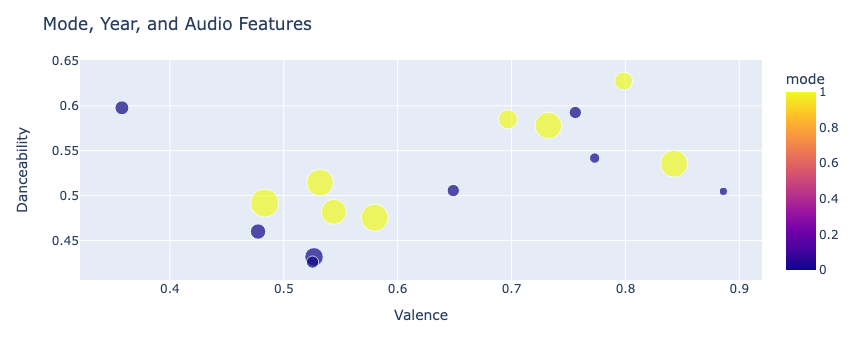

In [14]:
fig = px.scatter(beatles_mode_feature_count_final, 
                x='valence', 
                y='danceability',
                color='mode',
                size='title_count',
                hover_data={
                    'danceability': ':.3f',
                    'valence': ':.3f',
                    'mode': True,
                    'year': True,
                    'title_count': True
                }
                )

# Customize the plot
fig.update_layout(
    title='Mode, Year, and Audio Features',
    xaxis_title='Valence',
    yaxis_title='Danceability'
)

# Show the plot
fig.show()

# Counts of Mode By Year

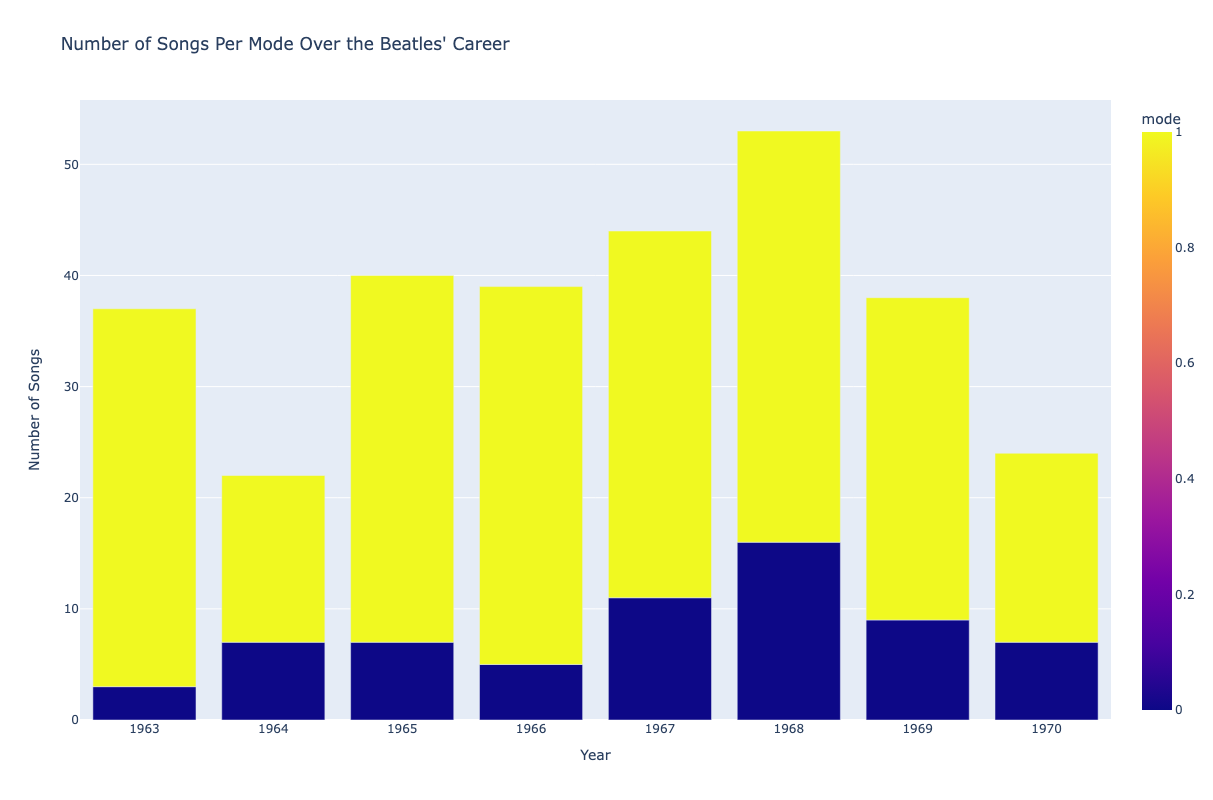

In [18]:
# Create the bar plot
fig = px.bar(
    beatles_mode_feature_count_final,
    x='year',
    y='title_count',
    color='mode',
    barmode='group',
    labels={
        'x': 'Year',
        'y': 'Count'
    },
    title="Number of Songs Per Mode Over the Beatles' Career"
)

# Customize the plot
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Songs",
    showlegend=True,

    width=800,  # Set width to 800px
    height=800,  # Set height to 800px
)

# Show the plot
fig.show()